# Testando scripts úteis

## Imprime configurações das instâncias presentes na pasta

In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import re

def instances_params(folderpath):
    regex = re.compile(r"(?P<letter>\w)(?P<value>[\d_]+)")

    exp_list = []
    for filename in os.listdir(folderpath):
        filepath = os.path.join(folderpath, filename)

        if os.path.isfile(filepath) and 'vrp' in filepath:
            filename = os.path.basename(filepath)
            instance_name = filename.split('.')[0]

            param_dict = {}

            for param_pair_str in instance_name.split('-'):
                m = regex.match(param_pair_str)

                if m != None:
                    param_dict[m.group('letter')] = m.group('value')
            if 'd' in param_dict.keys():
                param_dict['d'] = param_dict['d'].replace('_', ', ')

            exp_list.append(param_dict)

    exp_list.sort(key=lambda el: (int(el['n']), int(el['m']), int(el['Q']), int(el['s']), el['d']))
    
    letters = ['n', 'm', 'Q', 'v', 'd']
    for l in letters:
        print(l, end='\t')
    print('')
    
    for exp in exp_list:

        for l in letters:
            print(exp[l], end='\t')
        print('')

folderpath = "Instancias/Vrp-Set-A_MMURP/test"
instances_params(folderpath)

n	m	Q	v	d	
50	4	80	4	1, 1, 1, 1	
50	4	80	6	2, 2, 1, 1	
50	4	80	10	3, 3, 2, 2	
50	4	160	4	1, 1, 1, 1	
50	4	160	5	2, 1, 1, 1	
100	2	100	3	2, 1	
100	2	100	6	3, 3	
100	2	100	9	5, 4	
100	2	100	15	8, 7	
100	4	100	6	2, 2, 1, 1	
100	4	100	9	3, 2, 2, 2	
100	4	100	12	3, 3, 3, 3	
100	4	100	15	4, 4, 4, 3	
249	2	500	20	10, 10	
249	2	500	25	13, 12	
249	2	500	5	3, 2	
249	2	500	10	5, 5	
249	2	500	15	8, 7	


## Carrega dados associados à execução do algoritmo NSGAII

Caso existam arquivos de pós processamento, `.csv` (com todas as possíveis soluções que estejam associadas aos big tour encontrados na última iteração), estes serão usados

In [50]:
from src.util_experiments import nsga_output_to_df, read_out_file, read_pos_processed_csv

def nsga_output_to_df_(folderpath):
    """
        Iterate over files with extension '.out' and 
        returns a DataFrame with configurations and 
        output results
        Usage:
            folderpath = "../project/resultados/exp_20221005/n50/"
            df = nsga_output_to_df(folderpath)
    """
    
    all_results = []
    for filepath in glob.glob(f"{folderpath}/*.out"):
        if os.path.isfile(filepath):
            df, params = read_out_file(filepath)
            pop = df[['dist', 'demand']].dropna().values * [1, -1]        
            ref_point = [float(a) for a in params['ref_point'].split(',')]
            hv = mo.hypervolume(pop, ref_point)
            
            non_dominated, _ = mo.no_dominated(pop)

            params = {**params, 'hv':hv, 'non_dominated': len(non_dominated)}

            csv_path = filepath.replace('.out', '.csv')
            if os.path.isfile(csv_path):
                df_pp = read_pos_processed_csv(csv_path)
                
                pop_pp = df_pp[['dist', 'demand']].values * [1, -1]        
                hv_pp = mo.hypervolume(pop_pp, ref_point)
                non_dominated_pp, _ = mo.no_dominated(pop_pp)
                
                params = {**params, 'hv_post_proc': hv_pp , 'non_dominated_post_proc': len(non_dominated_pp)}
            
            all_results.append(params)

    return pd.DataFrame(all_results)

In [99]:
from src.util_experiments import nsga_output_to_df, read_out_file
import os
import pandas as pd

post_proc_path_list = [
    "../project/resultados/exp_20221005/n50/n50_output_post_proc.csv",
    "../project/resultados/exp_20221005/n100/n100_output_post_proc.csv",
    "../project/resultados/exp_20221005/n249/n249_output_post_proc.csv"
]

frames = []
for filepath in post_proc_path_list:
    frames.append(pd.read_csv(filepath))

df_nsga = pd.concat(frames)

df_nsga.head()

,name,mutation_rate,number_generations,population_size,ref_point,duracao,hv,non_dominated,hv_post_proc,non_dominated_post_proc
0,A-n50-m4-Q80-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",24333.2,1.470274e+06,17,1.484403e+06,47
1,A-n50-m4-Q160-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",83562.9,2.767469e+06,15,2.889130e+06,68
2,A-n50-m4-Q80-v10-s100-d3_3_2_2,0.4,20.0,100.0,"4709.81, 0",2803080.0,3.315824e+06,24,3.452251e+06,118
3,A-n50-m4-Q80-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",26555.1,1.476775e+06,28,1.486254e+06,57
4,A-n50-m4-Q80-v6-s100-d2_2_1_1,0.4,20.0,100.0,"4709.81, 0",112607.0,2.173878e+06,29,2.203807e+06,76


## Boxplot dos hipervolumes

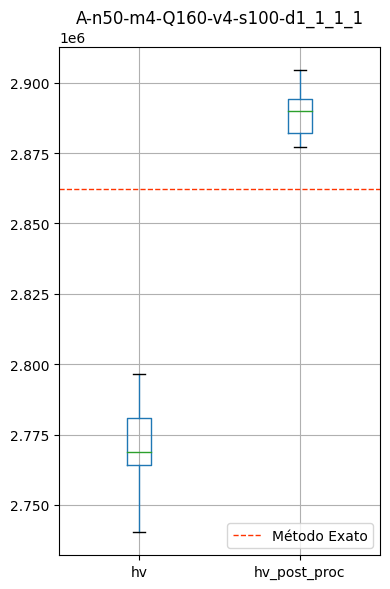

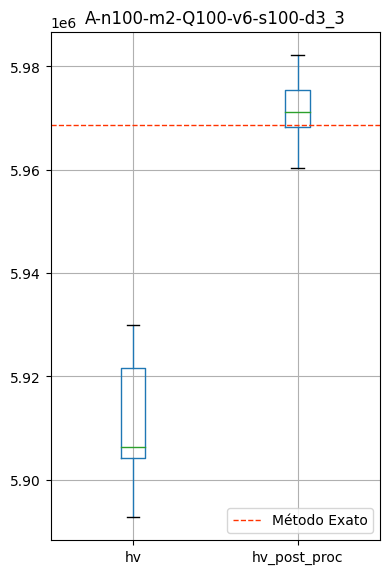

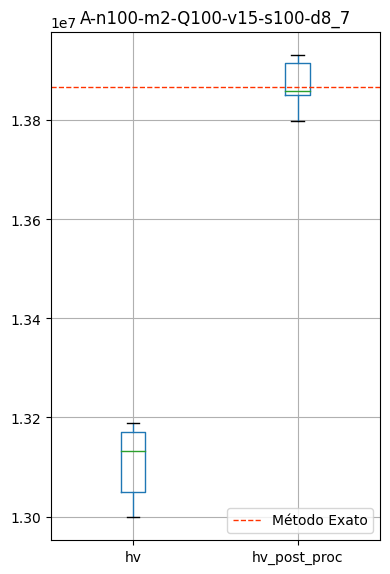

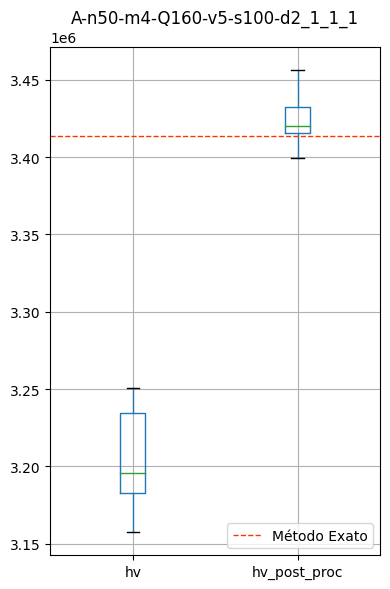

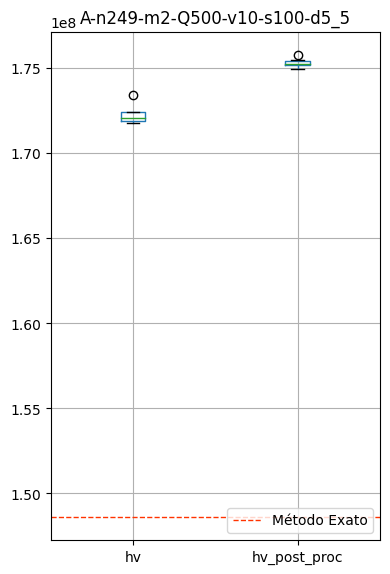

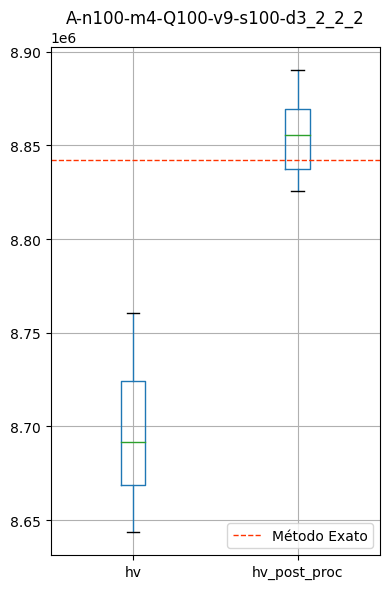

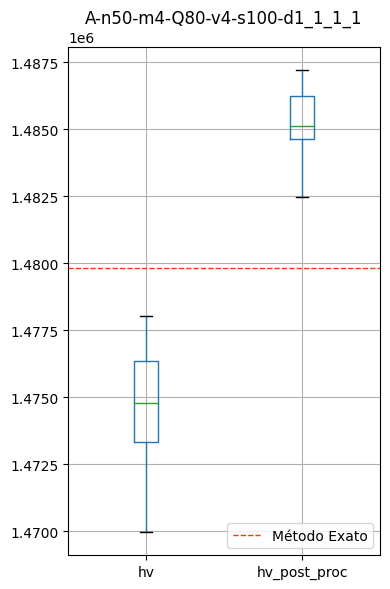

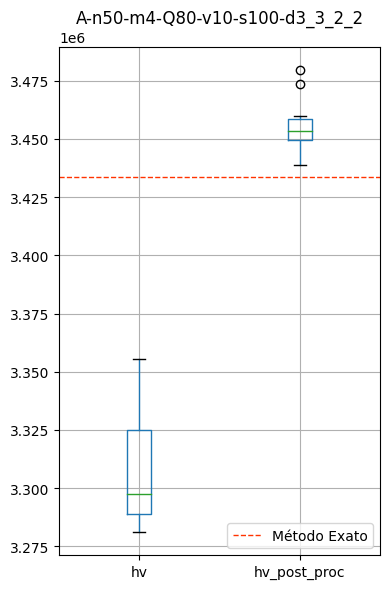

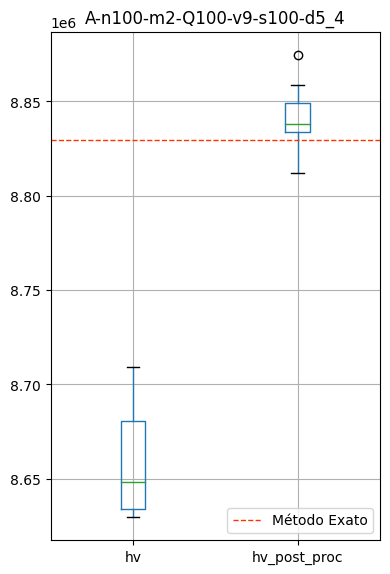

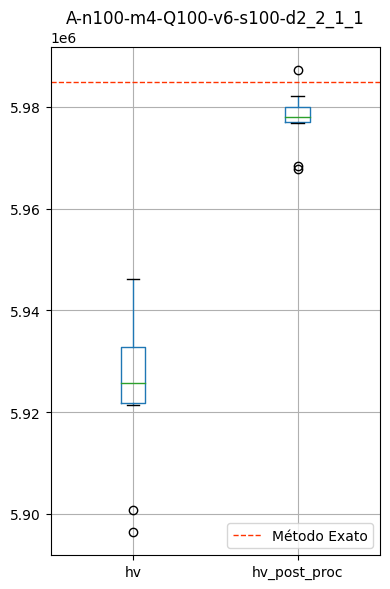

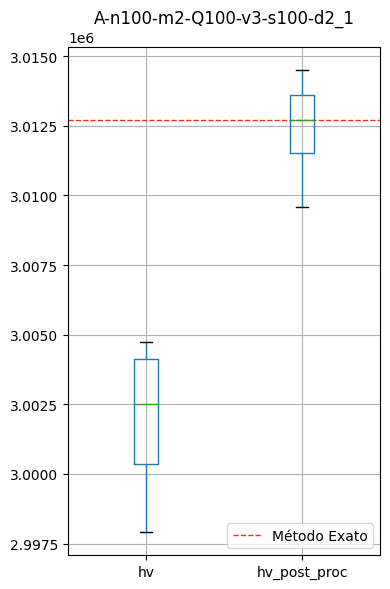

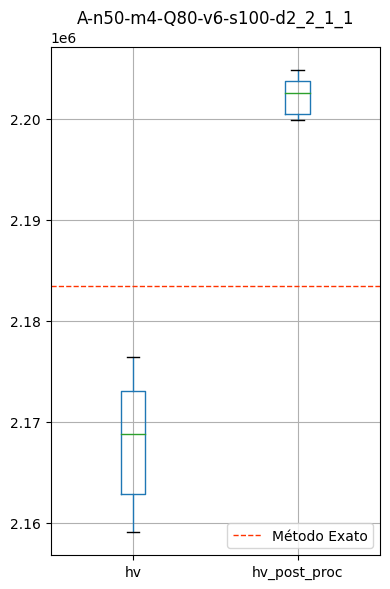

In [130]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt
import src.mo as mo

model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


# df_nsga = nsga_output_to_df(nsga_folderpath)

instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
    sol_path = solutions[0]
    df = clean_sol_csv_file(sol_path)
    pop = df[['dist', 'demand']].values*[1, -1]
    
    ref_point = [float(v) for v in df_nsga[df_nsga.name == instance].ref_point.values[0].split(',')]
    hv_model = mo.hypervolume(pop, ref_point)
    
    df_nsga[df_nsga.name == instance].boxplot(column=['hv', 'hv_post_proc'], figsize=(4, 6))
    
    plt.axhline(y=hv_model, color='#ff3300', linestyle='--', linewidth=1, label='Método Exato')
    plt.title(instance)
    
    plt.tight_layout()
    plt.legend(loc='lower right')

    plt.savefig(f"{instance}.pdf")
    plt.show()
#     break

In [5]:
import re
import pandas as pd
import glob

def parser_result_exp(filepath):
    
    def end_of_run(line):
        return '*****************' in line
    
    def read_starting(line):
        return str(line.split('Starting on instance')[1].strip())

    def read_build_model_time(line):
        return float(line.split(' ')[1].strip())

    def read_build_pareto_time(line):
        return float(line.split(' ')[1].strip())


    readers = {
        'Starting on instance': ('instance', read_starting),
        'build_model:': ('build_model', read_build_model_time),
        'build_pareto:': ('build_pareto', read_build_pareto_time),
    #     '': '',
    }

    runned_instances = []
    with open(filepath, mode='r') as file:
        instance_dict = {}
        for line in file:
            if end_of_run(line):
                runned_instances.append({**instance_dict})
                instance_dict = {}
            
            for reader in readers:
                reader_name = readers[reader][0]
                if reader_name in line:
                    reader_f = readers[reader][1]
                    instance_dict[reader_name] = reader_f(line)
                    break

    return pd.DataFrame(runned_instances)

search_path = '../project/resultados/exp_20220927/exp_*.log'

frames = []
for filepath in glob.glob(search_path):
    frames.append(parser_result_exp(filepath))

df_model = pd.concat(frames)

# folderpath = "../project/resultados/exp_20221005/n50/"
# df_nsga = nsga_output_to_df(folderpath)
# df_nsga
df_model

,instance,build_model,build_pareto
0,A-n100-m2-Q100-v12-s100-d6_6,2.080380,3493.713222
1,A-n100-m2-Q100-v15-s100-d8_7,0.998253,3456.927857
2,A-n100-m2-Q100-v3-s100-d2_1,0.963839,1272.239816
3,A-n100-m2-Q100-v6-s100-d3_3,0.966998,3490.143905
4,A-n100-m2-Q100-v9-s100-d5_4,0.970399,3492.164961
0,A-n100-m4-Q100-v12-s100-d3_3_3_3,0.995159,3494.672982
1,A-n100-m4-Q100-v15-s100-d4_4_4_3,0.998995,3495.434477
2,A-n100-m4-Q100-v3-s100-d1_1_1_0,0.995408,359.178795
3,A-n100-m4-Q100-v6-s100-d2_2_1_1,0.999574,3489.892184
4,A-n100-m4-Q100-v9-s100-d3_2_2_2,1.003205,3494.754386


* tempo para gerar (modelo e pareto)
* quantidade de pontos não dominados
* hipervolume

In [6]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

def model_pareto_folder_to_df(folderpath):
    """
    Given a folder with solutions of model on csv, returns a dataframe
    with all the found points
    """
    df_out = None
    for model_path in glob.glob(f"{folderpath}/*_sol_*.csv"):    
        df = clean_sol_csv_file(model_path)
        instance_name = os.path.basename(model_path).split('_sol_')[0].strip()

        df['instance'] = instance_name
        df = df.set_index('instance')

        if isinstance(df_out, pd.DataFrame):
            df_out = pd.concat([df_out, df])
        else:
            df_out = df
    return df_out

#     ref_point = [float(v) for v in df_nsga[df_nsga.name == instance].ref_point.values[0].split(',')]
#     hv_model = mo.hypervolume(pop, ref_point)

model_folderpath = "../project/resultados/exp_20220927/"
df_out = model_pareto_folder_to_df(model_folderpath)

df_out.head()
# df_out.groupby('instance').count()['dist']

,dist,demand,gap,status
instance,,,,
A-n249-m2-Q500-v15-s100-d8_7,14024.091539,7381,0.016122,FEASIBLE
A-n249-m2-Q500-v15-s100-d8_7,11489.170625,6756,0.016122,FEASIBLE
A-n249-m2-Q500-v15-s100-d8_7,11314.526392,6647,0.016122,FEASIBLE
A-n249-m2-Q500-v15-s100-d8_7,298.139379,78,0.016122,FEASIBLE
A-n249-m2-Q500-v15-s100-d8_7,0.000000,0,0.016122,FEASIBLE


In [62]:
# df_pareto_model.head()


instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
    sol_path = solutions[0]
    df = clean_sol_csv_file(sol_path)
    pop = df[['dist', 'demand']].values*[1, -1]
    
    ref_point = [float(v) for v in df_nsga[df_nsga.name == instance].ref_point.values[0].split(',')]
    hv_model = mo.hypervolume(pop, ref_point)
    

          dist  demand       gap    status
0  1485.012484     639  0.001565  FEASIBLE
1  1370.759185     626  0.001565  FEASIBLE
2  1399.226473     623  0.001565  FEASIBLE
3  1288.834499     601  0.001565  FEASIBLE
4  1207.509460     555  0.001565  FEASIBLE


In [107]:
import src.mo as mo

def model_logs_to_df(search_path):
    """
    Usage:
        search_path = '../project/resultados/exp_20220927/exp_*.log'
        df_model = model_logs_to_df(search_path)
    """
    
    frames = []
    for filepath in glob.glob(search_path):
        frames.append(parser_result_exp(filepath))
        
    df_model = pd.concat(frames)
    return df_model

def calc_hv_nd_df(df_model, df_pareto_model, df_nsga):
    instances = df_model.instance.values

    nsga_instances = list(set(df_nsga.name.values))

    number_of_non_dominated = []
    model_hv_list = []
    for instance in instances:
        try:
            pop = df_pareto_model.loc[instance, ['dist', 'demand']].values*[1, -1]
            non_dom, _ = mo.no_dominated(pop)
            number_of_non_dominated.append(len(non_dom))

            if instance in nsga_instances:
                ref_point = [float(v) for v in df_nsga[df_nsga.name == instance].ref_point.values[0].split(',')]
                hv_model = mo.hypervolume(pop, ref_point)
                model_hv_list.append(hv_model)
            else:
                model_hv_list.append(None)
        except:
            number_of_non_dominated.append(None)
            model_hv_list.append(None)

    df_model['nd_solutions'] = number_of_non_dominated 
    df_model['hv'] = model_hv_list

    return df_model

search_path = '../project/resultados/exp_20220927/exp_*.log'
df_model = model_logs_to_df(search_path)


model_folderpath = "../project/resultados/exp_20220927/"
df_pareto_model = model_pareto_folder_to_df(model_folderpath)

df_model = calc_hv_nd_df(df_model, df_pareto_model, df_nsga).dropna().reset_index().drop(columns=['index'])
df_model

,instance,build_model,build_pareto,nd_solutions,hv
0,A-n100-m2-Q100-v15-s100-d8_7,0.998253,3456.927857,5.0,1.386761e+07
1,A-n100-m2-Q100-v3-s100-d2_1,0.963839,1272.239816,4.0,3.012725e+06
2,A-n100-m2-Q100-v6-s100-d3_3,0.966998,3490.143905,6.0,5.968693e+06
3,A-n100-m2-Q100-v9-s100-d5_4,0.970399,3492.164961,5.0,8.829833e+06
4,A-n100-m4-Q100-v6-s100-d2_2_1_1,0.999574,3489.892184,5.0,5.984994e+06
5,A-n100-m4-Q100-v9-s100-d3_2_2_2,1.003205,3494.754386,8.0,8.842167e+06
6,A-n249-m2-Q500-v10-s100-d5_5,5.541151,3532.158579,7.0,1.486157e+08
7,A-n50-m4-Q160-v4-s100-d1_1_1_1,0.315368,3483.099560,8.0,2.862182e+06
8,A-n50-m4-Q160-v5-s100-d2_1_1_1,0.318783,2680.610028,5.0,3.413799e+06
9,A-n50-m4-Q80-v10-s100-d3_3_2_2,0.318352,3320.782163,6.0,3.433778e+06


In [111]:
def agg_nsga_model_df(df_model, nsga_path):
    """
        Usage:
            out_path = "../project/resultados/exp_20221005/n249/n249_output_post_proc.csv"
            result = agg_nsga_model_df(df_model, nsga_path)
            
    """
    df = pd.read_csv(nsga_path)
    # df = nsga_output_to_df(folderpath)

    df_nsga_mean = (df[['name', 'duracao', 'hv', 'non_dominated', 'hv_post_proc', 'non_dominated_post_proc']].groupby(by='name').mean()).reset_index()

    df_nsga_count = df[['name', 'duracao']].groupby(by='name').count()
    df_nsga_count.columns = ['count']
    df_nsga_count = df_nsga_count.reset_index()

    result = pd.merge(
        df_nsga_mean,
        df_model,
        how='left',
        left_on='name',
        right_on='instance',
        suffixes=('_nsga', '_model')
    )
    result.drop(columns=['instance'], inplace=True)

    result = pd.merge(
        result,
        df_nsga_count,
        how='left',
        on='name'
    )

    return result

In [112]:
post_proc_path_list = [
    "../project/resultados/exp_20221005/n50/n50_output_post_proc.csv",
    "../project/resultados/exp_20221005/n100/n100_output_post_proc.csv",
    "../project/resultados/exp_20221005/n249/n249_output_post_proc.csv"
]

df_out = None
for path in post_proc_path_list:
    df = agg_nsga_model_df(df_model, path)
    if isinstance(df_out, pd.DataFrame):
        df_out = pd.concat([df_out, df])
    else:
        df_out = df
        
df_out = df_out.reset_index().drop(columns='index')
df_out

,name,duracao,hv_nsga,non_dominated,hv_post_proc,non_dominated_post_proc,build_model,build_pareto,nd_solutions,hv_model,count
0,A-n50-m4-Q160-v4-s100-d1_1_1_1,83154.10,2.769714e+06,17.500,2.889205e+06,80.500,0.315368,3483.099560,8.0,2.862182e+06,10
1,A-n50-m4-Q160-v5-s100-d2_1_1_1,238904.90,3.203795e+06,12.100,3.424919e+06,105.300,0.318783,2680.610028,5.0,3.413799e+06,10
2,A-n50-m4-Q80-v10-s100-d3_3_2_2,2954781.00,3.309000e+06,26.400,3.455503e+06,117.100,0.318352,3320.782163,6.0,3.433778e+06,10
3,A-n50-m4-Q80-v4-s100-d1_1_1_1,26992.93,1.474365e+06,24.700,1.485258e+06,53.700,0.324585,3096.733128,5.0,1.479825e+06,10
4,A-n50-m4-Q80-v6-s100-d2_2_1_1,117235.20,2.167940e+06,31.200,2.202263e+06,76.900,0.315963,3418.887884,5.0,2.183454e+06,10
5,A-n100-m2-Q100-v15-s100-d8_7,2835968.00,1.311077e+07,33.400,1.387357e+07,183.200,0.998253,3456.927857,5.0,1.386761e+07,10
6,A-n100-m2-Q100-v3-s100-d2_1,20416.80,3.002101e+06,17.500,3.012441e+06,37.800,0.963839,1272.239816,4.0,3.012725e+06,10
7,A-n100-m2-Q100-v6-s100-d3_3,90573.50,5.911093e+06,29.600,5.971587e+06,73.100,0.966998,3490.143905,6.0,5.968693e+06,10
8,A-n100-m2-Q100-v9-s100-d5_4,314188.80,8.658280e+06,39.900,8.841823e+06,121.600,0.970399,3492.164961,5.0,8.829833e+06,10
9,A-n100-m4-Q100-v6-s100-d2_2_1_1,390994.60,5.924297e+06,32.500,5.977547e+06,79.300,0.999574,3489.892184,5.0,5.984994e+06,10


In [113]:
df_out.to_csv("agg_nsga_model.csv")

In [ ]:
folderpath = "../project/resultados/exp_20221005/n50/"

out_path = os.path.join(folderpath, "n50_output_post_proc.csv")
df = pd.read_csv(out_path)
# df = nsga_output_to_df(folderpath)

df_nsga_mean = (df[['name', 'duracao', 'hv', 'non_dominated', 'hv_post_proc', 'non_dominated_post_proc']].groupby(by='name').mean()).reset_index()

result = pd.merge(
    df_nsga_mean,
    df_model,
    how='left',
    left_on='name',
    right_on='instance'
)
result.drop(columns=['instance'], inplace=True)
result

In [ ]:
# df_nsga_mean.columns = ['name', 'duracao', 'hv', 'non_dminated']

folderpath = "../project/resultados/exp_20221005/n50/"
df = nsga_output_to_df(folderpath)

df

## Gerando gráficos

### Quantidade de pontos não dominados por instância

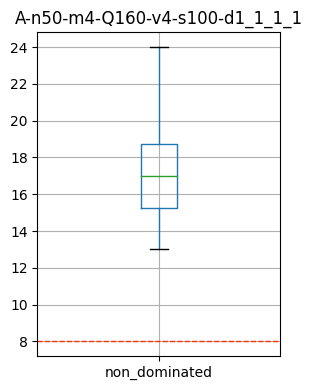

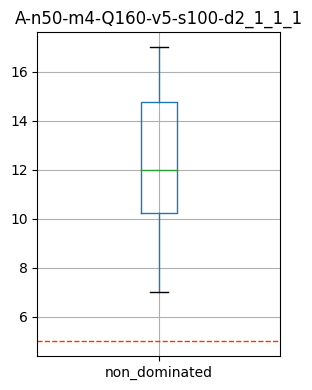

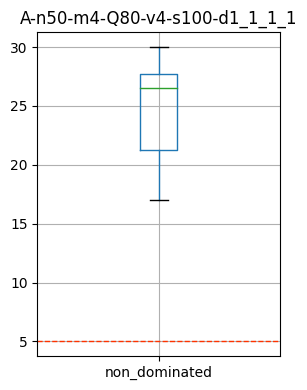

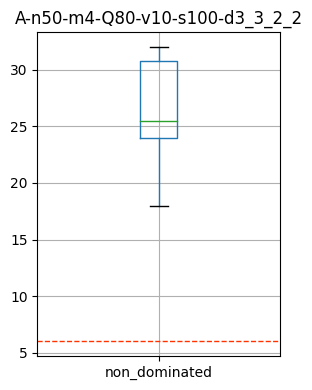

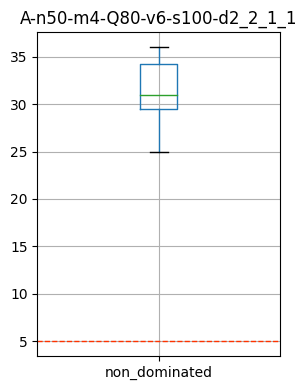

In [63]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

# model_folderpath = "../project/resultados/exp_20220927/"
# nsga_folderpath = "../project/resultados/exp_20221005/n50/"


# df_nsga = nsga_output_to_df(nsga_folderpath)
instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
    sol_path = solutions[0]
    df = clean_sol_csv_file(sol_path)
    pop = df[['dist', 'demand']].values*[1, -1]
    non_dominated, _ = mo.no_dominated(pop)
            
    df_nsga[df_nsga.name == instance].boxplot(column='non_dominated', figsize=(3, 4))
    
    plt.axhline(y=len(non_dominated), color='#ff3300', linestyle='--', linewidth=1, label='Model Non Dominated')
    plt.title(instance)
    
    plt.tight_layout()

    plt.show()
#     break

### Tempo de execução do algoritmo por instância

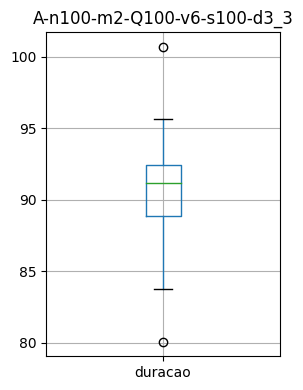

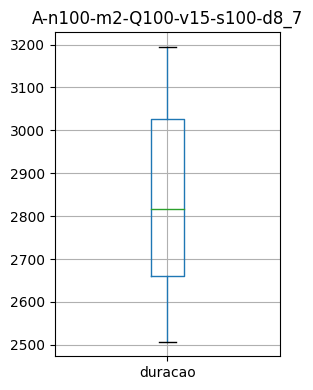

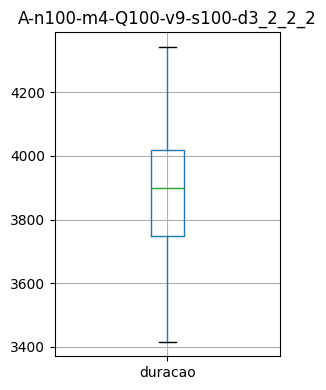

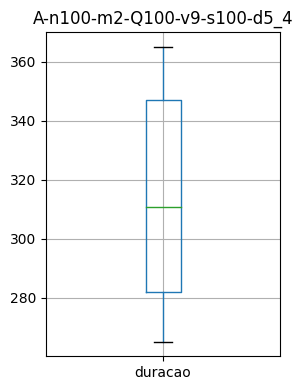

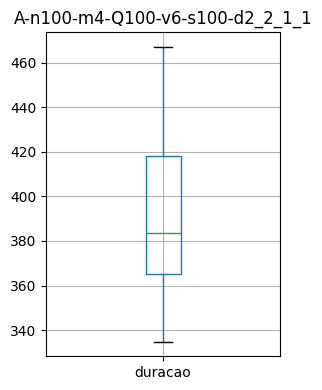

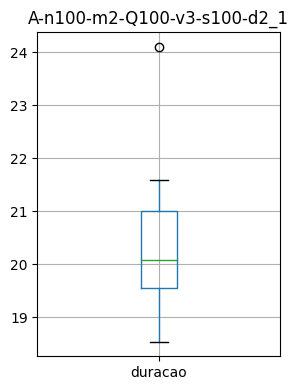

In [14]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


# df_nsga = nsga_output_to_df(nsga_folderpath)
df_nsga['duracao'] = df_nsga.duracao / 1000.0

instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
#     sol_path = solutions[0]
#     df = clean_sol_csv_file(sol_path)
#     pop = df[['dist', 'demand']].values*[1, -1]
#     non_dominated, _ = mo.no_dominated(pop)
            
    df_nsga[df_nsga.name == instance].boxplot(column='duracao', figsize=(3, 4))
    
#     plt.axhline(y=len(non_dominated), color='#ff3300', linestyle='--', linewidth=1, label='Model Non Dominated')
    plt.title(instance)
    plt.tight_layout()

    plt.show()
#     break

In [ ]:
import matplotlib.pyplot as plt


figure, axis = plt.subplots(5, 1, figsize=(12, 24), tight_layout=True)

instances = list(set(df.name.values))

k = 0
for i in range(5):
    cur_axis = axis[i]

    if k < len(instances):
        inst_id = instances[i]
        instance_name = instances[i]
        avg = df[df.name == 'A-n50-m4-Q80-v6-s100-d2_2_1_1'].hv.mean()
        
        df[df.name == inst_id].boxplot(column='hv', ax=cur_axis)
        plt.scatter(0, avg, c='tab:orange', )
        
        cur_axis.set_title(f"{instance_name}")
    
    else:
        cur_axis.set_visible(False)
    k = k + 1